In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

In [3]:
# Define hartree2kcalpermol

AVOGADROS_NUMBER = 6.022140857e23
HARTREE_TO_EV = 27.211386024367243
EV_TO_JOULE = 1.6021766208e-19
JOULE_TO_KCAL = 1 / 4184.0
HARTREE_TO_JOULE = HARTREE_TO_EV * EV_TO_JOULE
HARTREE_TO_KCALPERMOL = HARTREE_TO_JOULE * JOULE_TO_KCAL * AVOGADROS_NUMBER

def hartree2kcalpermol(x):
    r"""Hartree to kJ/mol conversion factor from CODATA 2014"""
    return x * HARTREE_TO_KCALPERMOL

In [4]:
df = pd.read_parquet('2xr_force-just-stdev.pq')

In [5]:
df = pd.read_parquet('2xr_force-just-stdev.pq')

# Define atomic numbers for species of interest
atom_types = {1: "H", 6: "C", 7: "N", 8: "O"}

df["n_atoms"] = df["species"].apply(len)

# Apply hartree2kcalpermol to data frame:
df["energy_mean"] = df["energy_mean"].apply(hartree2kcalpermol)
df["energy_qbc"] = df["energy_qbc"].apply(hartree2kcalpermol)
df["dataset_energy"] = df["dataset_energy"].apply(hartree2kcalpermol)

df['energy_error'] = abs(df['dataset_energy']-df['energy_mean'])
df["size_weighted_energy_error"] = df["energy_error"] / np.sqrt(df["n_atoms"])

# Convert force magnitudes
df["force_magnitudes"] = df["force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])
df["mean_magnitudes"] = df["force_magnitudes"].apply(lambda x: np.mean(np.vstack(x), axis=0))
df["dataset_force_magnitudes"] = df["dataset_force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])
df["force_stdev"] = df["force_stdev"].apply(lambda x: [hartree2kcalpermol(f) for f in x])
df["mean_stdev"] = df["mean_stdev"].apply(hartree2kcalpermol)

print("All energies and forces converted to kcal/mol!")


All energies and forces converted to kcal/mol!


In [6]:
print(df.iloc[0], len(df))

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
force_magnitudes              [[48.13782304418484, 25.053821658468664, 28.62...
force_stdev                   [0.8746520836005943, 2.3191027411361005, 1.118...
mean_stdev                                                             1.447427
n_atoms                                                                      20
energy_error                                                           0.640466
size_weighted_energy_error                                             0.143213
mean_magnitudes               [49.098190

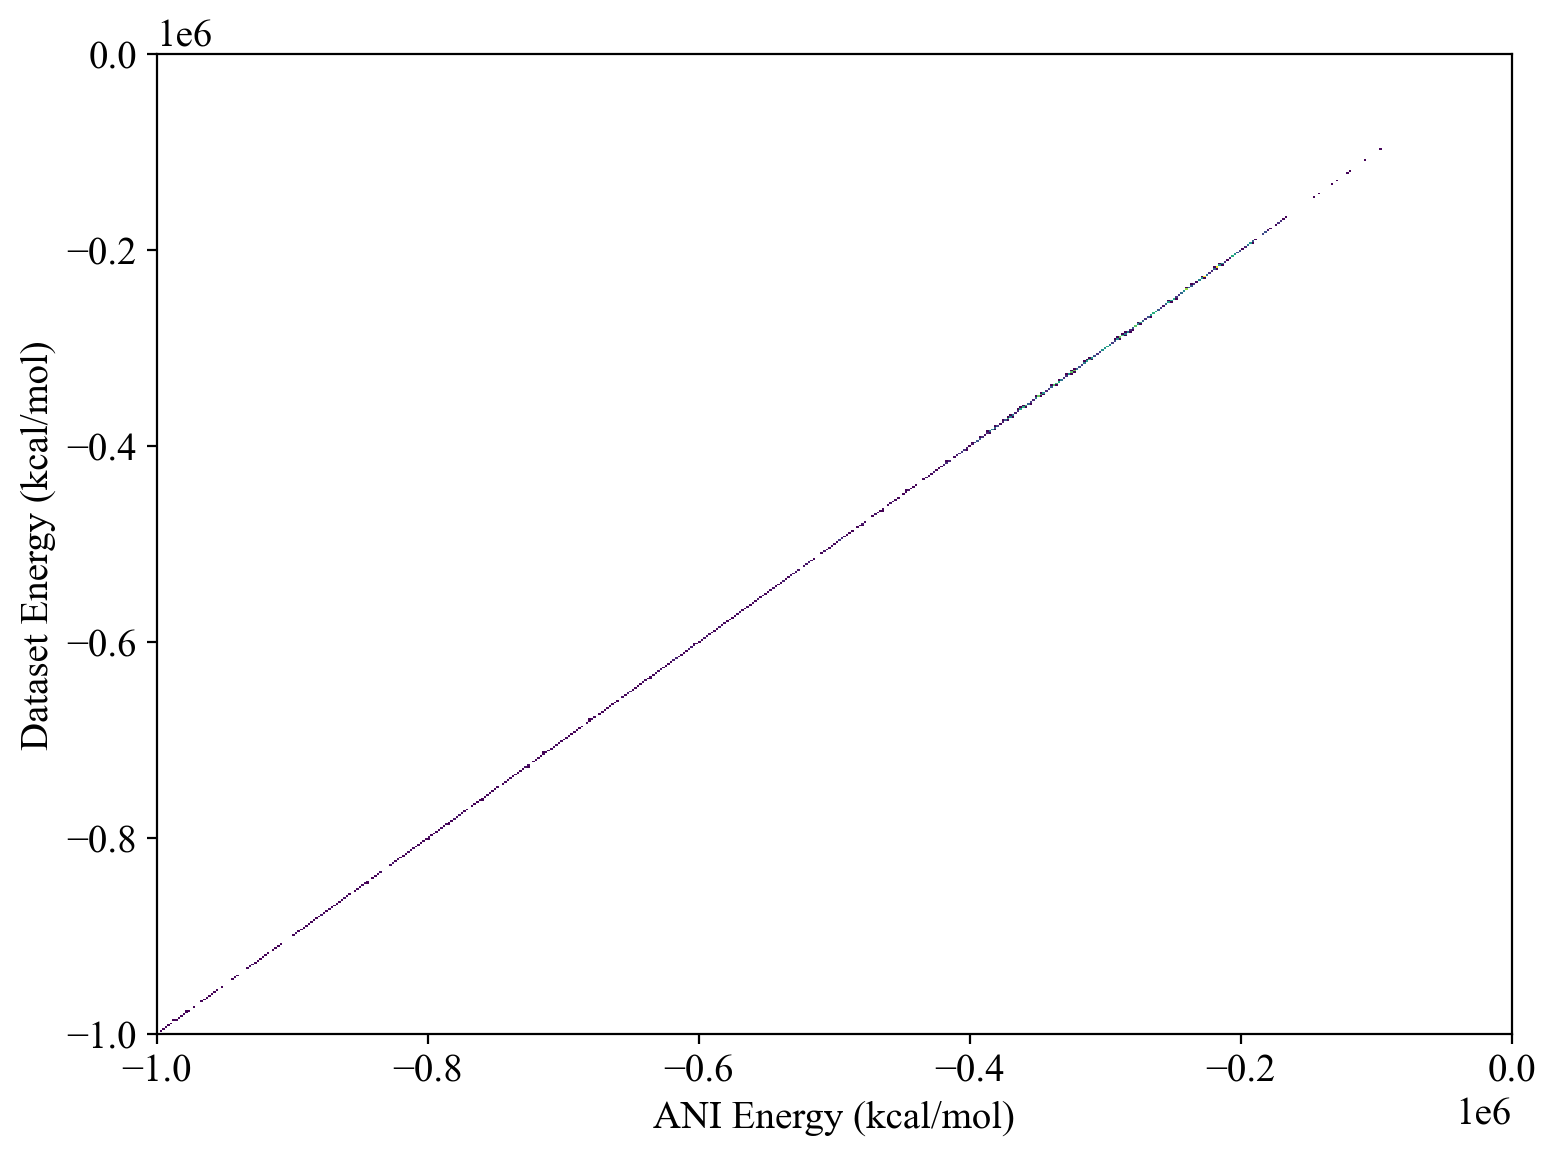

In [19]:

plt.figure(figsize=(8,6))
plt.hist2d(df['energy_mean'], df['dataset_energy'], bins=[2500,2500], cmin=1)

plt.xlabel("ANI Energy (kcal/mol)")
plt.ylabel("Dataset Energy (kcal/mol)")
# Add colorbar with bin count
#cbar_ax = plt.gca().inset_axes([0.86, 0.25, 0.02, 0.4])  # [x-position, y-position, width, height]
#cb = plt.colorbar(hb, cax=cbar_ax)
#cb.set_label("Count")  # Label the colorbar
plt.xlim(-1e6, 0)  # Adjust based on main cluster range
plt.ylim(-1e6, 0)  # Adjust based on main cluster range

plt.tight_layout()
#plt.savefig('./figures/forces/qbc-vs-energy_error')

plt.show()


In [7]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (20, 12)
plt.rcParams["figure.dpi"] = 200

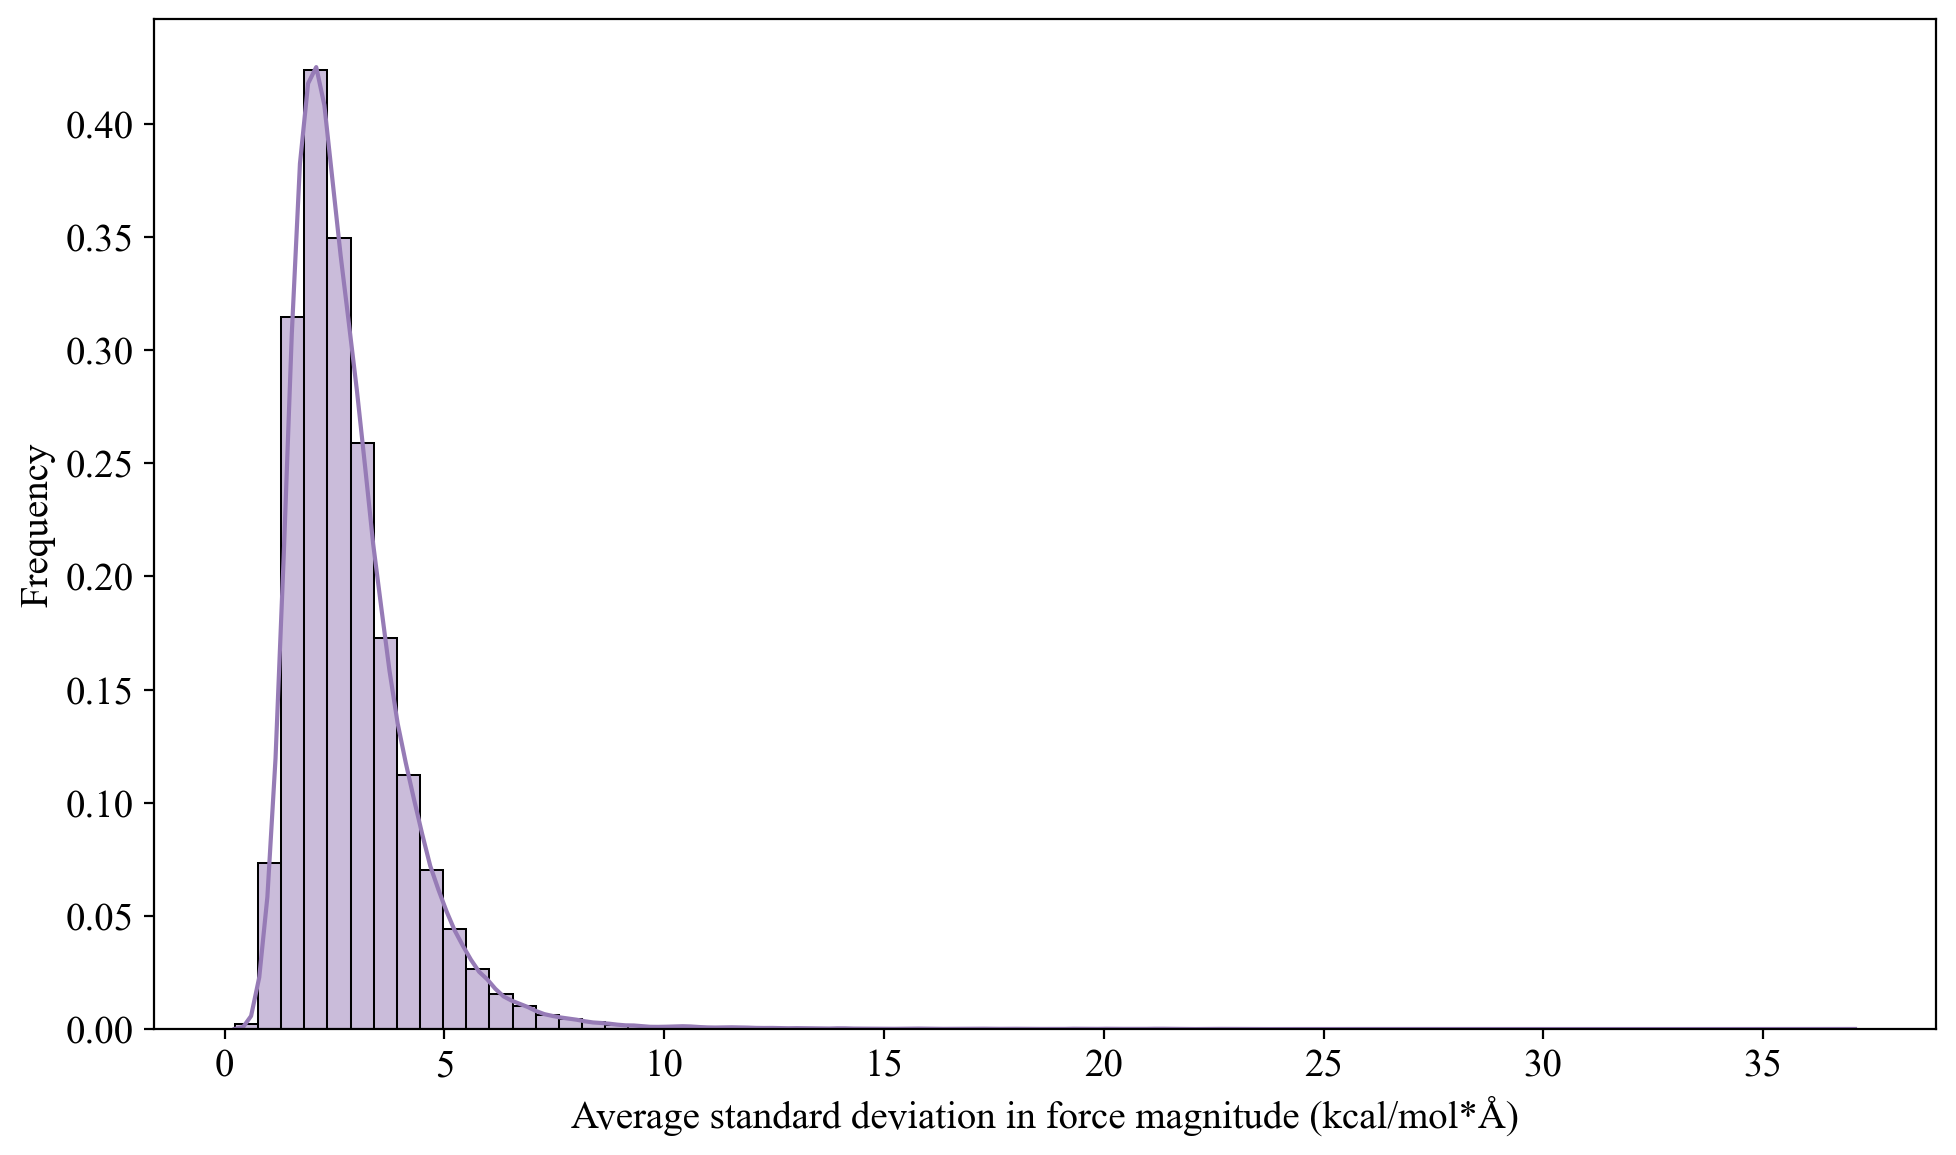

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(df["mean_stdev"], bins=70, kde=True, color="#967BB6", edgecolor="black", stat='density')

# Labels and title
plt.xlabel("Average standard deviation in force magnitude (kcal/mol*Å)")
plt.ylabel("Frequency")
#plt.title("Distribution of Total Energy QBC")
plt.tight_layout()
plt.savefig('figures/forces/2xr_force_just_stdev.png')

plt.show()

In [8]:
correlation_qbc = df["size_weighted_energy_error"].corr(df["energy_qbc"])
print(f"Correlation between size_weighted_energy_error and energy_qbc: {correlation_qbc:.3f}")


Correlation between size_weighted_energy_error and energy_qbc: 0.653


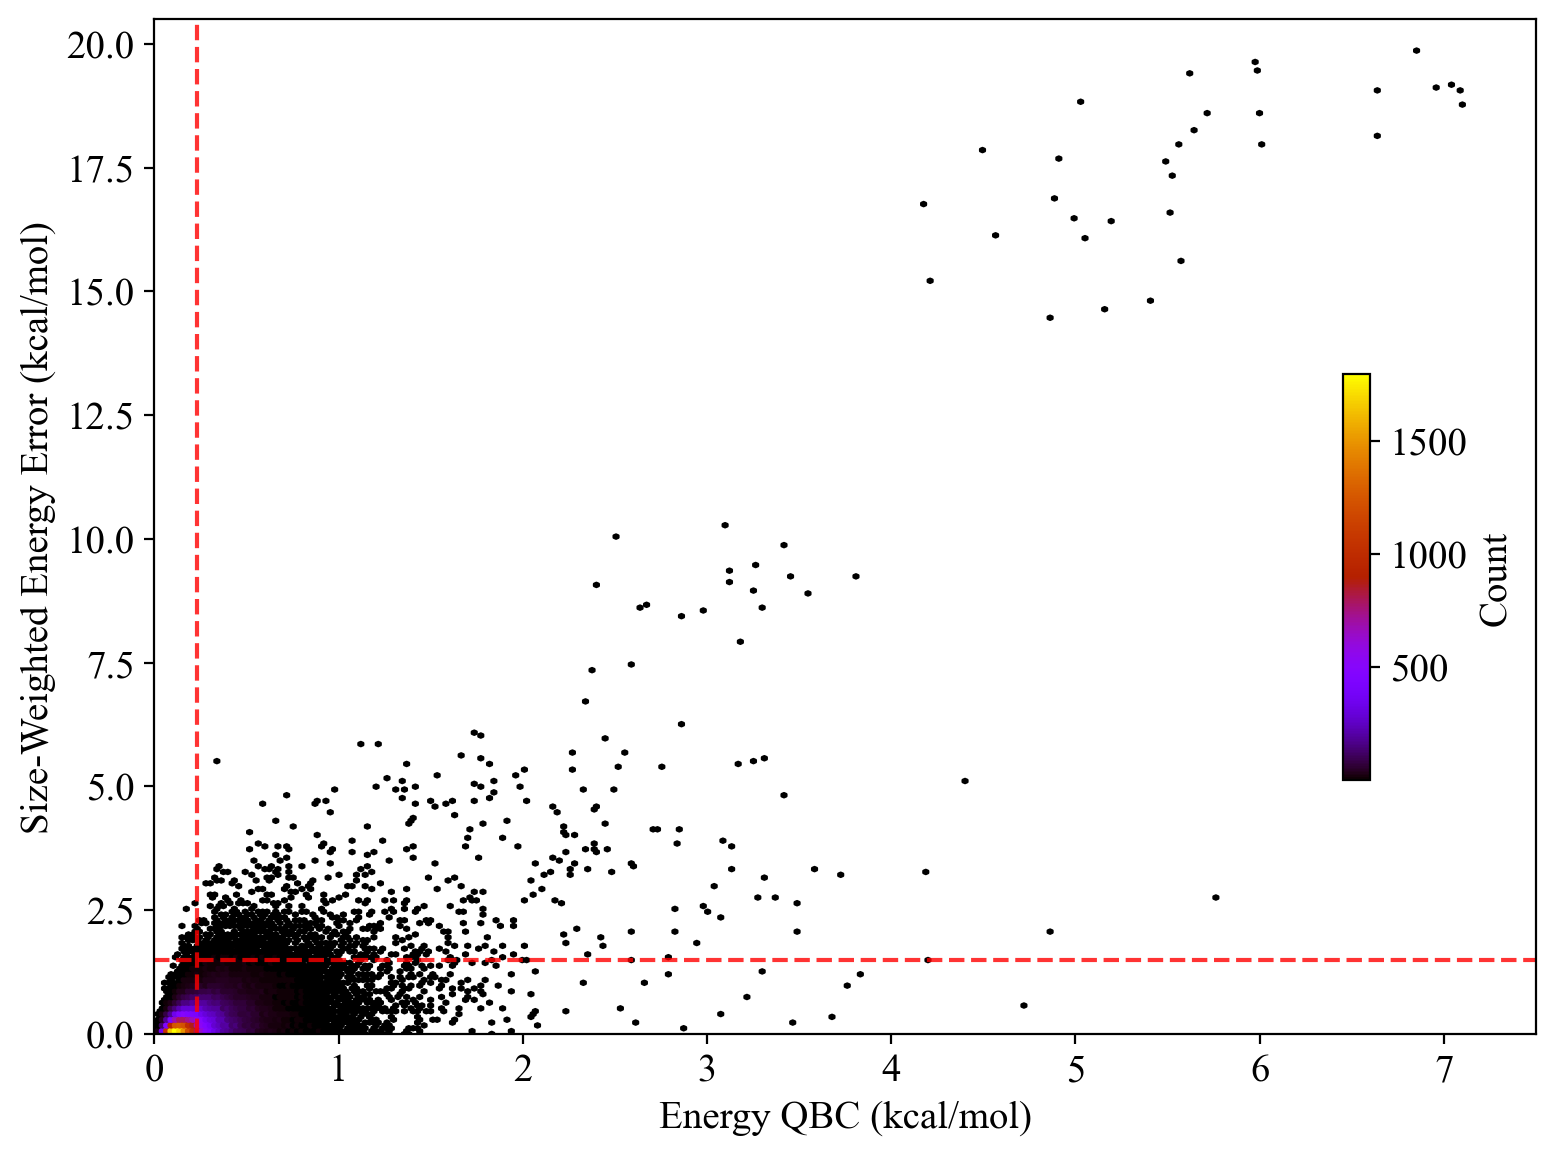

In [9]:

plt.figure(figsize=(8,6))
hb = plt.hexbin(df['energy_qbc'], df['size_weighted_energy_error'], gridsize=300, cmap="gnuplot", mincnt=1)

# Reference lines
plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Horizontal line at 1.5 kcal/mol
plt.axvline(x=0.23, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Vertical line at 0.23 kcal/mol

plt.xlabel("Energy QBC (kcal/mol)")
plt.ylabel("Size-Weighted Energy Error (kcal/mol)")
# Add colorbar with bin count
cbar_ax = plt.gca().inset_axes([0.86, 0.25, 0.02, 0.4])  # [x-position, y-position, width, height]
cb = plt.colorbar(hb, cax=cbar_ax)
cb.set_label("Count")  # Label the colorbar
plt.xlim(0, 7.5)  # Adjust based on main cluster range
plt.ylim(0, 20.5)  # Adjust based on main cluster range

plt.tight_layout()
plt.savefig('./figures/forces/qbc-vs-energy_error')

plt.show()


In [10]:
correlation_qbc = df["size_weighted_energy_error"].corr(df["mean_stdev"])
print(f"Correlation between energy_error and mean force magnitude stdev: {correlation_qbc:.3f}")

Correlation between energy_error and mean force magnitude stdev: 0.531


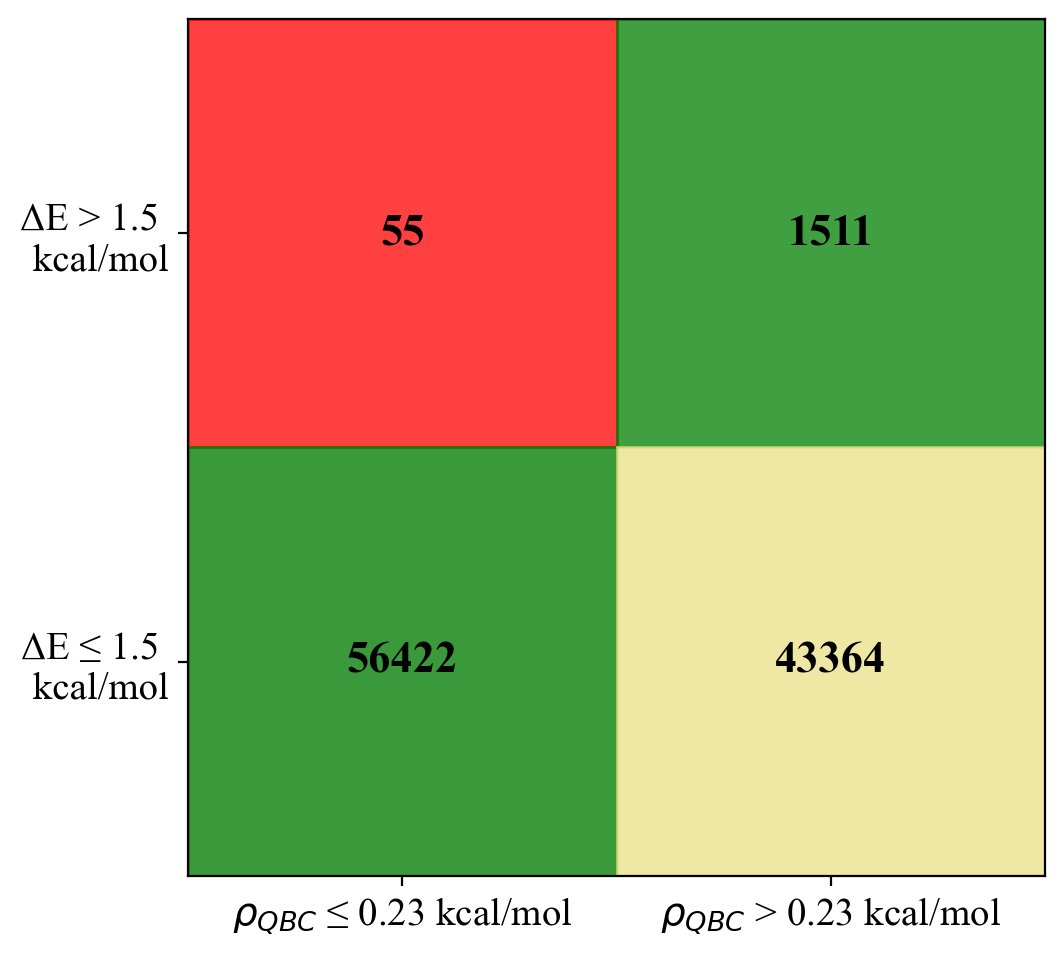

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define x and y thresholds
x_threshold = 0.23  # Example threshold for energy QBC
y_threshold = 1.5   # Example threshold for size-weighted energy error

# Load data for confusion matrix
df_conf_matrix = pd.DataFrame({
    "energy_qbc": df.groupby("id")["energy_qbc"].max(),
    "size_weighted_energy_error": df.groupby("id")["size_weighted_energy_error"].first()
}).reset_index()

# Classify points into quadrants
TP = ((df_conf_matrix["energy_qbc"] > x_threshold) & 
      (df_conf_matrix["size_weighted_energy_error"] > y_threshold)).sum()

FN = ((df_conf_matrix["energy_qbc"] <= x_threshold) & 
      (df_conf_matrix["size_weighted_energy_error"] > y_threshold)).sum()

TN = ((df_conf_matrix["energy_qbc"] <= x_threshold) & 
      (df_conf_matrix["size_weighted_energy_error"] <= y_threshold)).sum()

FP = ((df_conf_matrix["energy_qbc"] > x_threshold) & 
      (df_conf_matrix["size_weighted_energy_error"] <= y_threshold)).sum()

# Create confusion matrix
conf_matrix = np.array([[FN, TP], [TN, FP]])

# Define custom colors for each quadrant
color_map = np.array([["red", "green"],  # FN (light red), TP (green)
                      ["green", "khaki"]])   # TN (light green), FP (red)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
ax.matshow(conf_matrix, cmap="Greys", alpha=0.1)  # Light background

# Manually color each cell
for i in range(2):
    for j in range(2):
        ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1, color=color_map[i, j], alpha=0.75))

# Annotate each cell with the count
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", 
                color="black", fontsize=16, fontweight="bold")

# Set axis labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels([fr"$\rho_{{QBC}}$ ≤ {x_threshold} kcal/mol", 
                    fr"$\rho_{{QBC}}$ > {x_threshold} kcal/mol"])
ax.set_yticklabels([f"ΔE > {y_threshold} \n kcal/mol", f"ΔE ≤ {y_threshold} \n kcal/mol"])

ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()


# Rotate x-axis labels for readability
#plt.xticks(rotation=20)

# Add title
#plt.title("Confusion Matrix: QBC vs. Energy Error", fontsize=12)
plt.tight_layout()
plt.savefig('./figures/forces/QBC_confusion.png')
plt.show()

/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_10327/3165286395.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 1600x1200 with 1 Axes> than <Figure size 1600x1200 with 1 Axes> which fig.colorbar is called on.
  cb = plt.colorbar(hb, cax=cbar_ax)


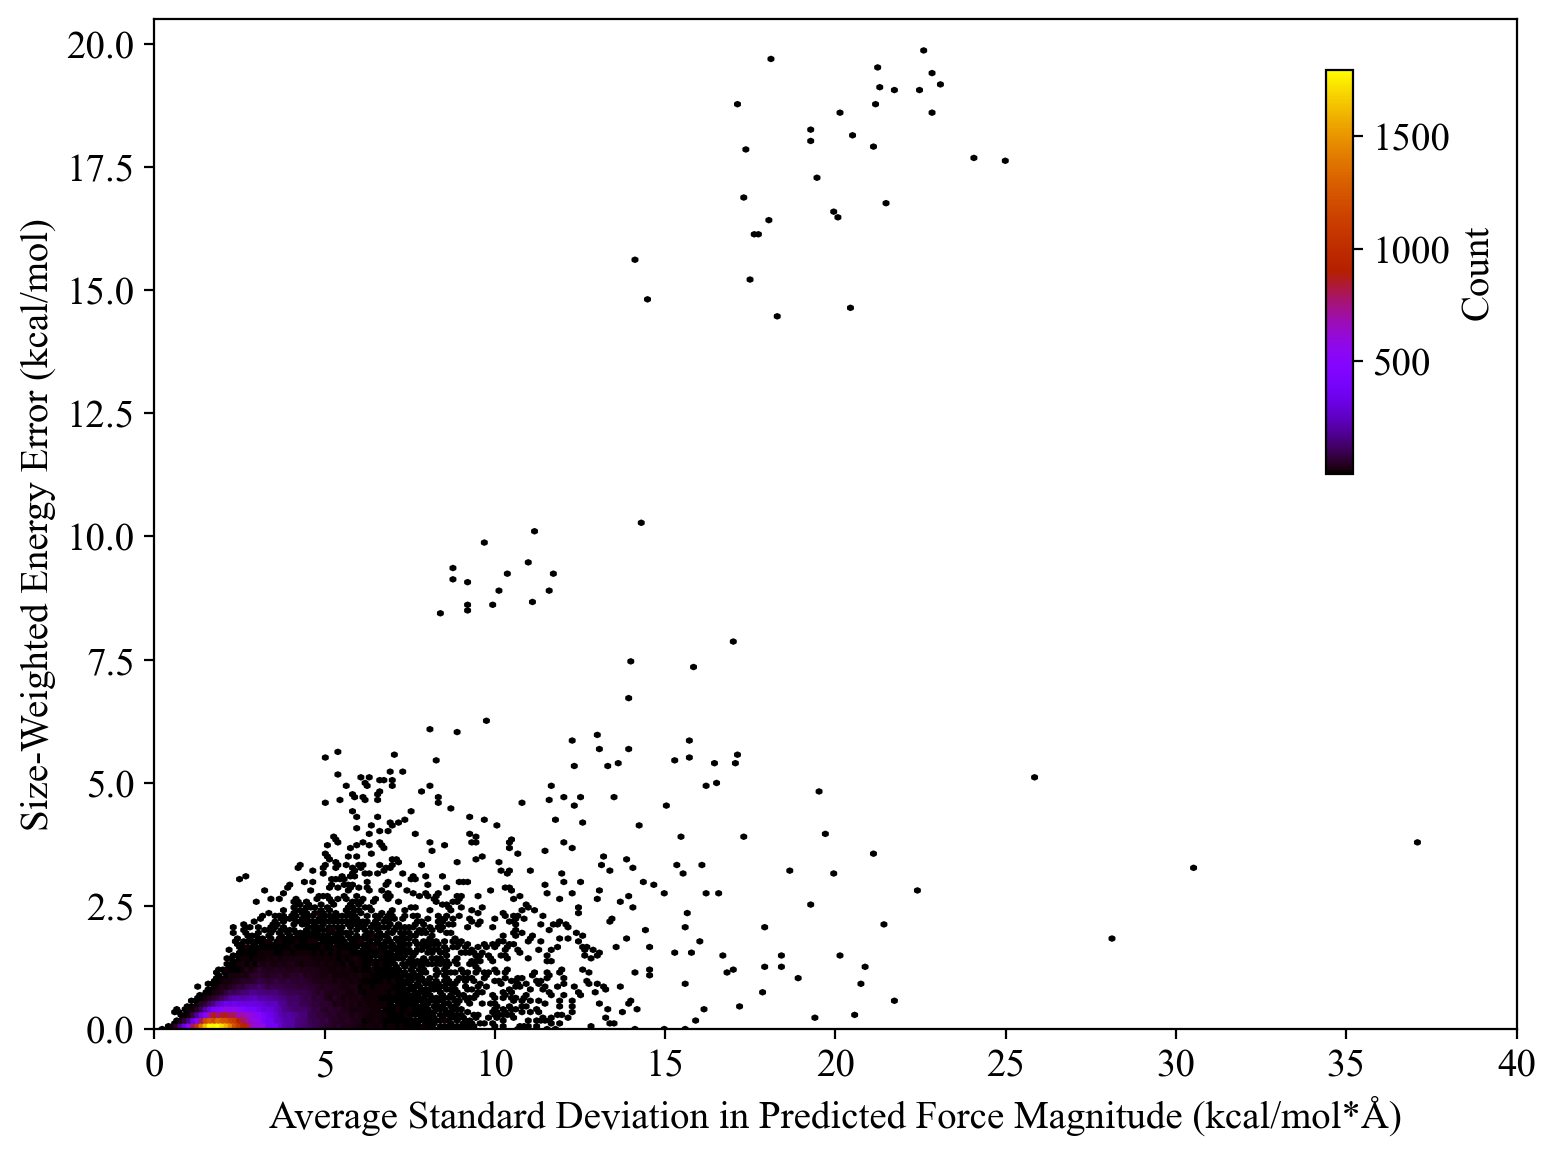

In [12]:

plt.figure(figsize=(8,6))
plt.hexbin(df['mean_stdev'], df['size_weighted_energy_error'], gridsize=300, cmap="gnuplot", mincnt=1)
#plt.colorbar(label="log(count)")

# Reference lines
#plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Horizontal line at 1.5 kcal/mol
#plt.axvline(x=3.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Vertical line at 0.23 kcal/mol

plt.xlabel("Average Standard Deviation in Predicted Force Magnitude (kcal/mol*Å)")
plt.ylabel("Size-Weighted Energy Error (kcal/mol)")
# Add colorbar with bin count
cbar_ax = plt.gca().inset_axes([0.86, 0.55, 0.02, 0.4])  # [x-position, y-position, width, height]
cb = plt.colorbar(hb, cax=cbar_ax)
cb.set_label("Count")  # Label the colorbar

plt.xlim(0,40)
plt.ylim(0,20.5)

plt.tight_layout()
plt.savefig('./figures/forces/force_stdev-vs-energy_error')

plt.show()


In [13]:
df.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
force_magnitudes              [[48.13782304418484, 25.053821658468664, 28.62...
force_stdev                   [0.8746520836005943, 2.3191027411361005, 1.118...
mean_stdev                                                             1.447427
n_atoms                                                                      20
energy_error                                                           0.640466
size_weighted_energy_error                                             0.143213
mean_magnitudes               [49.098190

In [14]:
def compute_weighted_force_stdev(force_stdev, mean_magnitudes):
    """
    Compute a weighted average of force standard deviations per molecule.

    Parameters:
    - force_stdev: (N_atoms,) list of standard deviations per atom.
    - mean_magnitudes: (N_atoms,) list of mean force magnitudes per atom.

    Returns:
    - A single weighted standard deviation value per molecule.
    """
    force_stdev = np.array(force_stdev)
    mean_magnitudes = np.array(mean_magnitudes)

    # Avoid division by zero
    total_weight = np.sum(mean_magnitudes)
    if total_weight == 0:
        return np.nan  # Return NaN if all weights are zero

    # Compute the weighted mean standard deviation
    weighted_stdev = np.sum(force_stdev * mean_magnitudes) / total_weight
    return weighted_stdev

# Apply the function across the dataframe
df["weighted_force_stdev"] = df.apply(
    lambda row: compute_weighted_force_stdev(row["force_stdev"], row["mean_magnitudes"]),
    axis=1
)

# Debug print for first row
print("Weighted force standard deviation for first molecule:", df["weighted_force_stdev"].iloc[0])

print(f"correlation: {df['weighted_force_stdev'].corr(df['size_weighted_energy_error'])}")

Weighted force standard deviation for first molecule: 1.6944071192150951
correlation: 0.5146575509762754


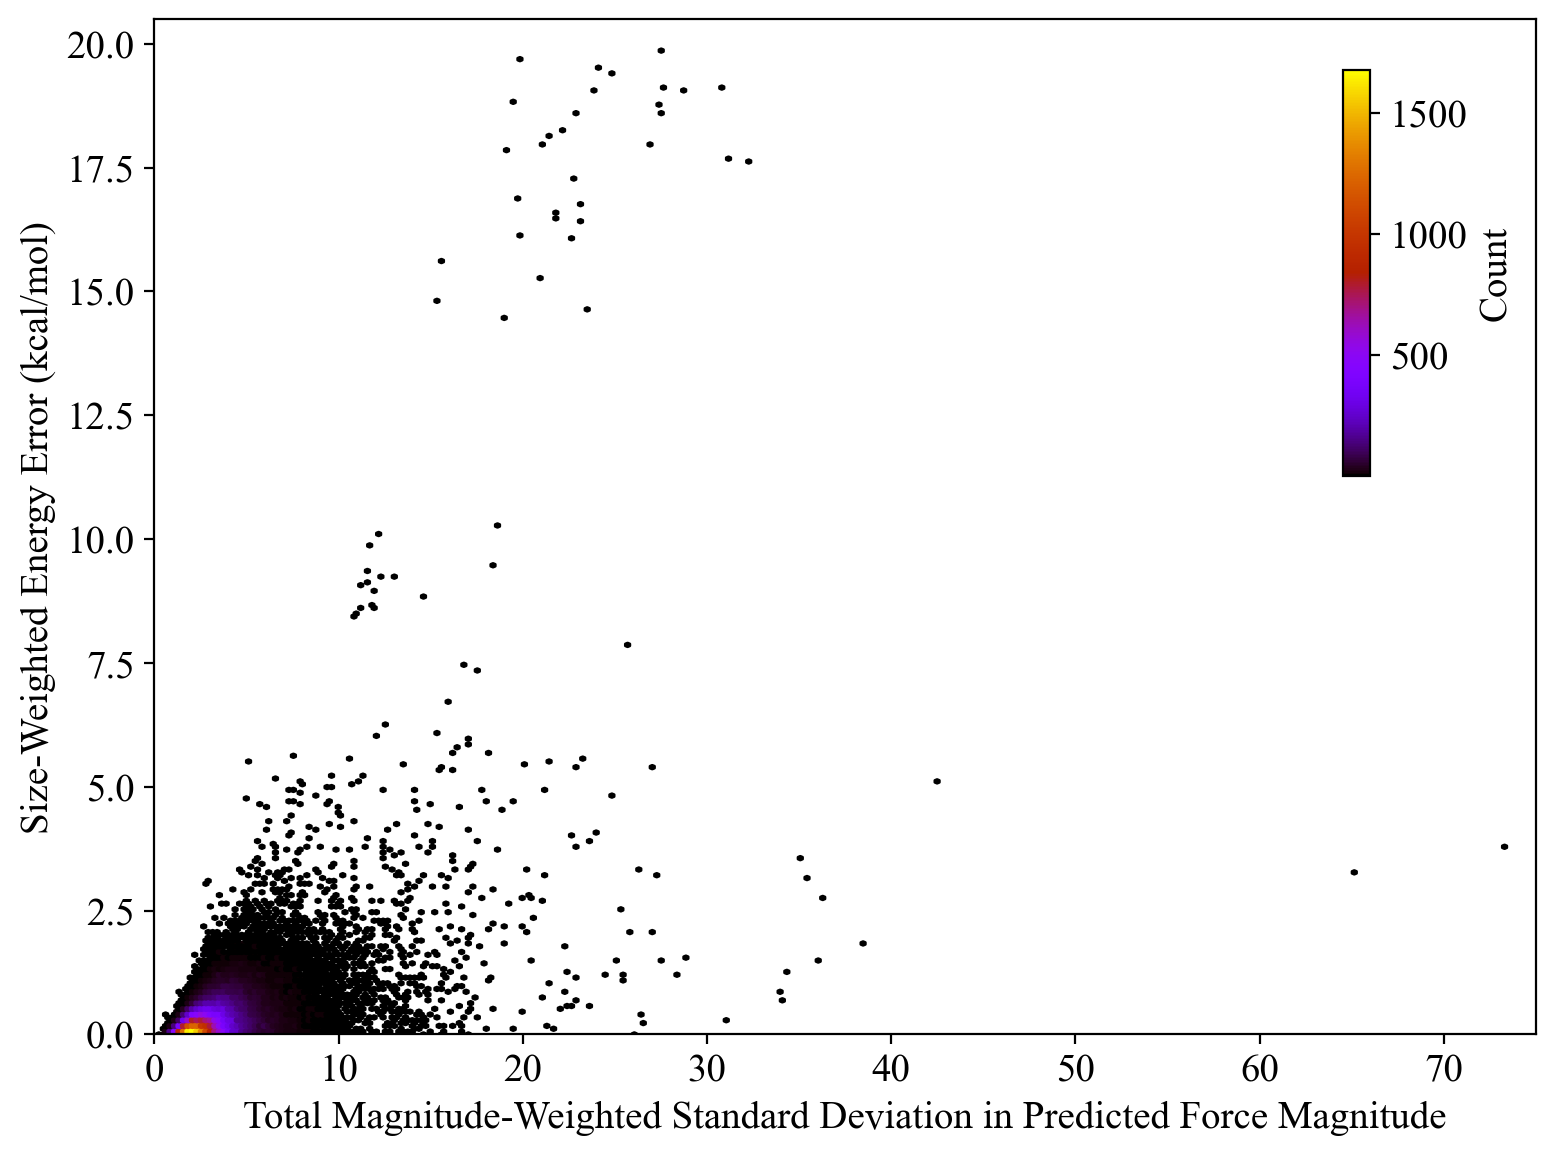

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Hexbin plot with weighted force stdev vs. energy error
hb = plt.hexbin(df["weighted_force_stdev"], df["size_weighted_energy_error"], 
                gridsize=300, cmap="gnuplot", mincnt=1)

plt.xlim(0,75)
plt.ylim(0,20.5)

# Add colorbar with bin count
cbar_ax = plt.gca().inset_axes([0.86, 0.55, 0.02, 0.4])  # [x-position, y-position, width, height]
cb = plt.colorbar(hb, cax=cbar_ax)
cb.set_label("Count")  # Label the colorbar

# Labels and layout
plt.xlabel("Total Magnitude-Weighted Standard Deviation in Predicted Force Magnitude")
plt.ylabel("Size-Weighted Energy Error (kcal/mol)")
plt.tight_layout()

# Save and show plot
plt.savefig('./figures/forces/weighted_force_stdev-vs-energy_error.png')
plt.show()

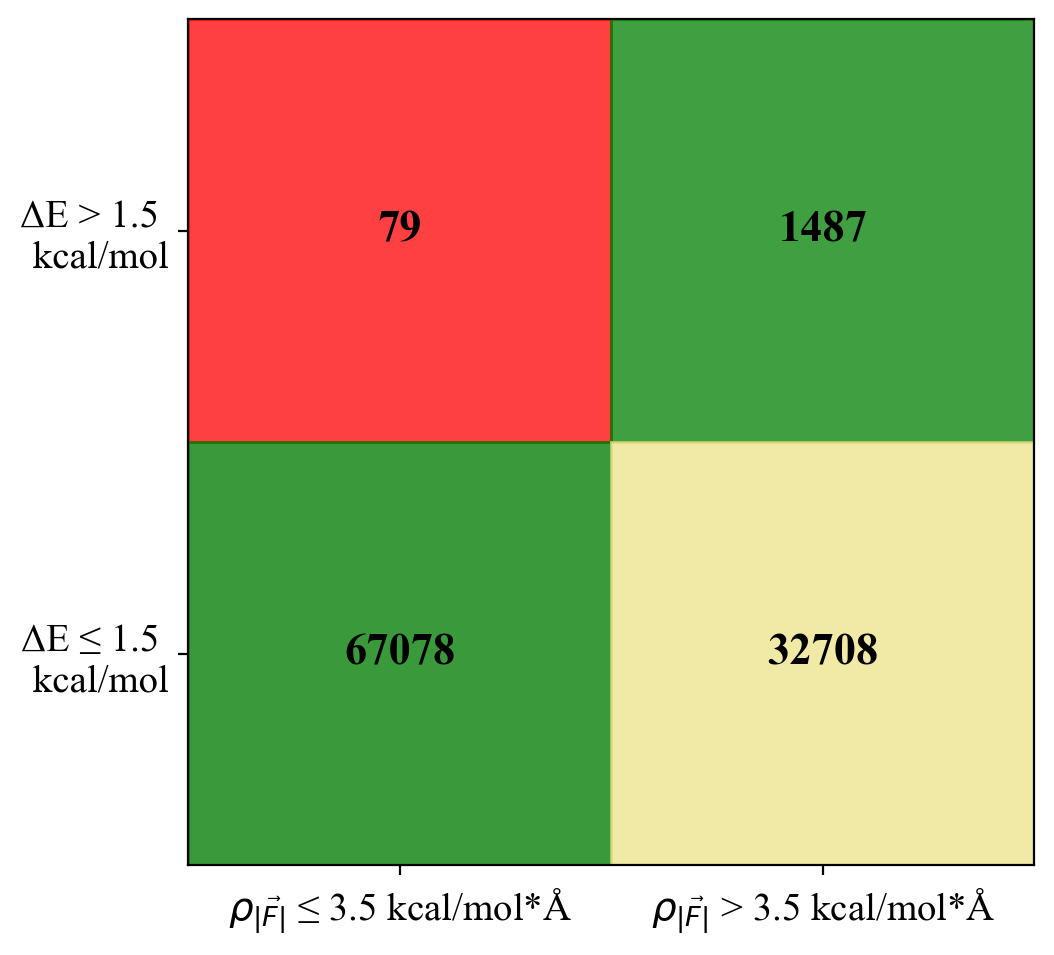

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define x and y thresholds
x_threshold = 3.5  # Example threshold for weighted force stdev
y_threshold = 1.5  # Example threshold for size-weighted energy error

# Load data for confusion matrix
df_conf_matrix = pd.DataFrame({
    "weighted_force_stdev": df.groupby("id")["weighted_force_stdev"].max(),
    "size_weighted_energy_error": df.groupby("id")["size_weighted_energy_error"].first()
}).reset_index()

# Classify points into quadrants
TP = ((df_conf_matrix["weighted_force_stdev"] > x_threshold) & 
      (df_conf_matrix["size_weighted_energy_error"] > y_threshold)).sum()

FN = ((df_conf_matrix["weighted_force_stdev"] <= x_threshold) & 
      (df_conf_matrix["size_weighted_energy_error"] > y_threshold)).sum()

TN = ((df_conf_matrix["weighted_force_stdev"] <= x_threshold) & 
      (df_conf_matrix["size_weighted_energy_error"] <= y_threshold)).sum()

FP = ((df_conf_matrix["weighted_force_stdev"] > x_threshold) & 
      (df_conf_matrix["size_weighted_energy_error"] <= y_threshold)).sum()

# Create confusion matrix
conf_matrix = np.array([[FN, TP], [TN, FP]])

# Define custom colors for each quadrant
color_map = np.array([["red", "green"],  # FN (light red), TP (green)
                      ["green", "khaki"]])   # TN (light green), FP (red)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
ax.matshow(conf_matrix, cmap="Greys", alpha=0.1)  # Light background

# Manually color each cell
for i in range(2):
    for j in range(2):
        ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1, color=color_map[i, j], alpha=0.75))

# Annotate each cell with the count
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", 
                color="black", fontsize=16, fontweight="bold")

# Set axis labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels([fr"$\rho_{{\vec{{|F|}}}}$ ≤ {x_threshold} kcal/mol*Å", 
                    fr"$\rho_{{\vec{{|F|}}}}$ > {x_threshold} kcal/mol*Å"])
ax.set_yticklabels([f"ΔE > {y_threshold} \n kcal/mol", f"ΔE ≤ {y_threshold} \n kcal/mol"])

# Move x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Rotate x-axis labels for readability
#plt.xticks(rotation=20)

# Add title
#plt.title("Confusion Matrix: Weighted Force Stdev vs. Energy Error", fontsize=12)
plt.tight_layout()
plt.savefig('./figures/forces/weighted_force_confusion_matrix.png')
plt.show()

In [17]:
np.array([['FP', 'TP'], ['TN', 'FN']])


array([['FP', 'TP'],
       ['TN', 'FN']], dtype='<U2')

In [18]:
df_high_error = df[df["size_weighted_energy_error"] >= 1.5]
stdev_threshold = np.percentile(df_high_error["weighted_force_stdev"], 5)
print(f"95th percentile of weighted_force_stdev for high-error molecules: {stdev_threshold:.4f}")

95th percentile of weighted_force_stdev for high-error molecules: 3.5012


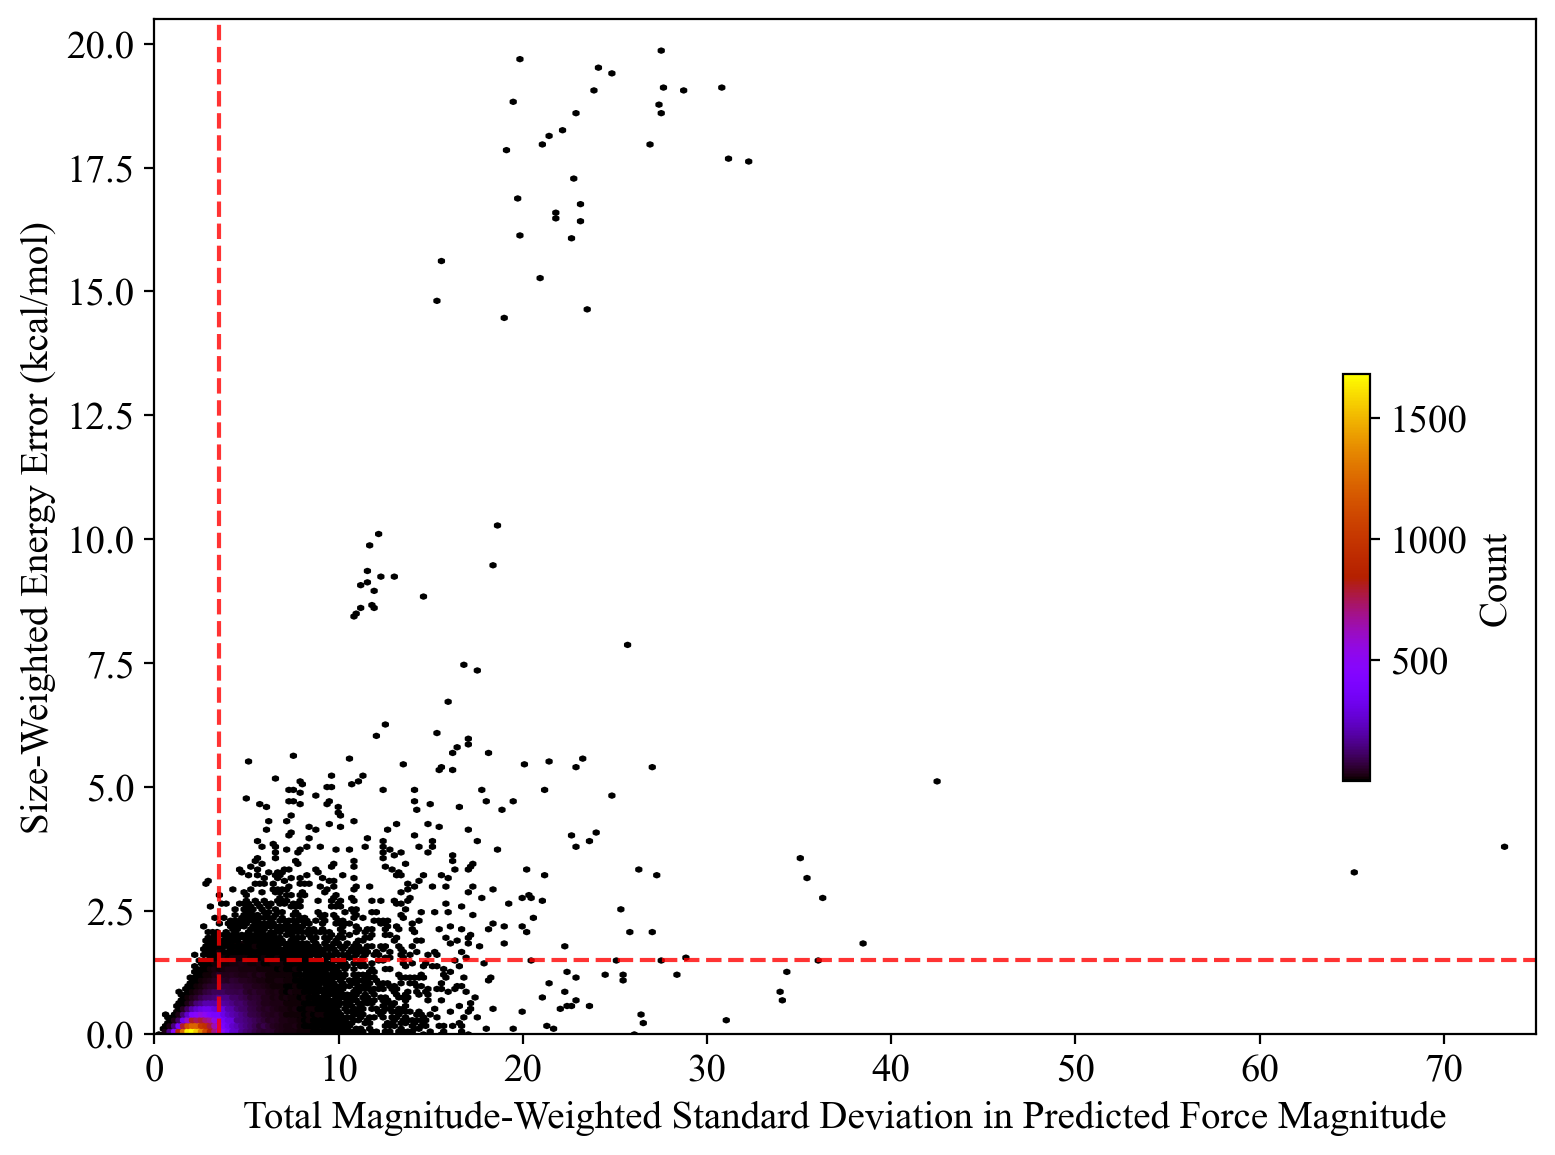

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Hexbin plot with weighted force stdev vs. energy error
hb = plt.hexbin(df["weighted_force_stdev"], df["size_weighted_energy_error"], 
                gridsize=300, cmap="gnuplot", mincnt=1)

plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Horizontal line at 1.5 kcal/mol
plt.axvline(x=3.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Vertical line at 0.23 kcal/mol


plt.xlim(0,75)
plt.ylim(0,20.5)

# Add colorbar with bin count
cbar_ax = plt.gca().inset_axes([0.86, 0.25, 0.02, 0.4])  # [x-position, y-position, width, height]
cb = plt.colorbar(hb, cax=cbar_ax)
cb.set_label("Count")  # Label the colorbar

# Labels and layout
plt.xlabel("Total Magnitude-Weighted Standard Deviation in Predicted Force Magnitude")
plt.ylabel("Size-Weighted Energy Error (kcal/mol)")
plt.tight_layout()

# Save and show plot
plt.savefig('./figures/forces/lines_weighted_force_stdev-vs-energy_error.png')
plt.show()

In [20]:
df['force_magnitudes'].iloc[0]

[array([48.13782304, 25.05382166, 28.62236416, 35.99455178, 61.00184008,
        86.19147014, 22.0821339 , 36.09270056, 84.98848485, 48.35127432,
        60.5416166 , 25.71699099, 64.15448571,  9.9287067 , 22.75088088,
        35.44430755, 50.12446976,  9.57991747, 12.14376451, 15.44798602]),
 array([48.48878921, 23.49103854, 26.38542239, 36.21720407, 56.8240299 ,
        88.30888995, 21.99643079, 31.74102028, 82.24256313, 46.07516047,
        58.65075764, 23.68323586, 62.50785091, 11.25001473, 21.42622298,
        34.07885757, 50.99205767,  9.06228878, 11.66536926, 14.90755409]),
 array([49.31047493, 29.86956385, 28.01002713, 40.31950332, 58.93662479,
        93.44283841, 23.19881063, 37.2816272 , 87.10091143, 49.74899094,
        59.64147918, 25.30400918, 64.83261136,  9.38198881, 21.49380693,
        35.44239067, 50.6728088 ,  8.57973485, 12.25437182, 15.57795145]),
 array([48.40782687, 26.42624252, 27.35830529, 32.9568954 , 59.33202042,
        87.3306468 , 23.65436816, 34.86577301

In [21]:
def compute_normalized_max_force_deviation(force_magnitudes):
    """
    Compute the normalized maximum force deviation per atom from ensemble force magnitude predictions.

    Parameters:
    - force_magnitudes: List of arrays (8, N_atoms), where each array represents force magnitudes 
                        predicted by one of the 8 models in the ensemble.

    Returns:
    - List of normalized max force deviation values per atom (N_atoms,).
    """
    # Convert to numpy array of shape (8, N_atoms)
    force_magnitudes = np.array(force_magnitudes)  # Shape: (8, N_atoms)

    # Compute the mean force magnitude per atom
    mean_magnitudes = np.mean(force_magnitudes, axis=0)  # Shape: (N_atoms,)

    # Compute absolute deviation from mean per atom
    deviations = np.abs(force_magnitudes - mean_magnitudes)  # Shape: (8, N_atoms)

    # Find the largest deviation for each atom across the ensemble
    max_deviation_per_atom = np.max(deviations, axis=0)  # Shape: (N_atoms,)

    # Normalize by the mean force magnitude
    normalized_max_deviation = max_deviation_per_atom / mean_magnitudes  # Shape: (N_atoms,)

    return normalized_max_deviation.tolist() 

df['max_dev_per_atom'] = df['force_magnitudes'].apply(compute_normalized_max_force_deviation)

In [35]:
df

,id,species,dataset_energy,dataset_force_magnitudes,energy_mean,energy_qbc,force_magnitudes,force_stdev,mean_stdev,n_atoms,energy_error,size_weighted_energy_error,mean_magnitudes,weighted_force_stdev,max_dev_per_atom
0,ANI-BenchMD-wB97X-631Gd/020-0-idx0,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323365.609936,"[44.131484527495964, 26.311531452815576, 25.28...",-323364.969469,0.085878,"[[48.13782304418484, 25.053821658468664, 28.62...","[0.8746520836005943, 2.3191027411361005, 1.118...",1.447427,20,0.640466,0.143213,"[49.098190141185654, 26.85269945158232, 27.365...",1.694407,"[0.03348088082467123, 0.12518893736568745, 0.0..."
1,ANI-BenchMD-wB97X-631Gd/020-0-idx1,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323375.401484,"[39.90579449573383, 42.71410354908396, 22.6242...",-323375.655208,0.070091,"[[41.20083663971648, 41.56735288484412, 22.299...","[0.6359971635789947, 1.5834672720881195, 1.680...",1.378904,20,0.253724,0.056735,"[40.334220610283225, 42.45017821373725, 21.037...",1.548208,"[0.024208787251625934, 0.06276388595975775, 0...."
2,ANI-BenchMD-wB97X-631Gd/020-0-idx2,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323370.103359,"[32.39333588265067, 27.210584197994482, 17.293...",-323368.799483,0.100496,"[[32.24356700497612, 28.140089574275752, 15.75...","[1.039288446790695, 1.8031485426135132, 2.9807...",1.407226,20,1.303876,0.291555,"[31.849795456311185, 30.179884918252565, 13.98...",1.659560,"[0.06677785461751554, 0.10346771966882817, 0.3..."
3,ANI-BenchMD-wB97X-631Gd/020-0-idx3,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323369.378915,"[55.316195699334884, 20.85518530750392, 38.170...",-323369.986787,0.059467,"[[52.511276245669904, 23.04918435281231, 45.76...","[1.004619270562752, 1.901515017683395, 2.83055...",1.146378,20,0.607873,0.135924,"[53.57105153523005, 21.443361794180028, 41.666...",1.244978,"[0.03902765324547635, 0.1254980143472609, 0.10..."
4,ANI-BenchMD-wB97X-631Gd/020-0-idx4,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323373.288524,"[44.80066631030287, 12.986574442537334, 34.206...",-323373.203999,0.058624,"[[45.071076884909246, 11.481863350306163, 37.3...","[1.4859953883489343, 0.7205842584632914, 3.132...",1.198938,20,0.084525,0.018900,"[46.30296085172402, 12.211921759044598, 35.621...",1.412688,"[0.044897585895784776, 0.08624239992867536, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101347,GDB13-13-wB97X-631Gd/038-0-idx19,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351292.843214,"[56.38688374663998, 99.01833249181533, 51.8240...",-351289.983660,0.258743,"[[58.424112637682775, 100.16477458560107, 53.2...","[1.8344672748768087, 5.865051218244619, 2.8677...",2.762944,38,2.859553,0.463881,"[55.53664824989208, 97.40339979961547, 52.3234...",3.140988,"[0.0577915050452239, 0.09076277766738572, 0.10..."
101348,GDB13-13-wB97X-631Gd/038-0-idx20,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351447.549823,"[58.203288399987684, 38.367510003035, 89.07974...",-351446.248227,0.124705,"[[57.75551526861469, 36.9294571418535, 93.2624...","[1.9304690658559953, 3.938810093582108, 2.3889...",2.169154,38,1.301596,0.211147,"[54.89127723604587, 36.01744005449951, 90.3562...",2.320278,"[0.0688879152790358, 0.14303057406107472, 0.04..."
101349,GDB13-13-wB97X-631Gd/038-0-idx21,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351393.836450,"[103.73138150396309, 38.26214254358094, 39.013...",-351392.359931,0.185799,"[[103.28251435007103, 30.195598927068794, 39.8...","[3.6645362519552673, 2.1136205329124813, 0.951...",2.008852,38,1.476518,0.239523,"[99.78272812977806, 33.85697700717948, 41.1139...",2.241445,"[0.053282000196392426, 0.108142498349285, 0.04..."
101350,GDB13-13-wB97X-631Gd/038-0-idx22,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351178.029168,"[88.13360322976702, 86.01770757416932, 66.6359...",-351174.661943,0.574317,"[[88.40958677378677, 100.90969171364897, 60.52...","[6.045414155146332, 2.6730067533662947, 3.9577...",3.58118

In [44]:
exploded_rows = []

for _, row in df.iterrows():
    n_atoms = len(row['species'])  # assumes all per-atom columns are same length
    exploded = pd.DataFrame({
        'species': row['species'],
        'mean_magnitudes': row['mean_magnitudes'],
        'max_dev_per_atom': row['max_dev_per_atom'],
        'weighted_force_stdev': [row['weighted_force_stdev']]*n_atoms,
        'size_weighted_energy_error': [row['size_weighted_energy_error']] * n_atoms,
        'id': [row['id']] * n_atoms  # optional: keep row metadata
    })
    exploded_rows.append(exploded)

df_exploded = pd.concat(exploded_rows, ignore_index=True)
df_exploded.iloc[244]

species                                                         6
mean_magnitudes                                         78.587447
max_dev_per_atom                                         0.035277
weighted_force_stdev                                     1.374161
size_weighted_energy_error                               0.148278
id                            ANI-BenchMD-wB97X-631Gd/020-0-idx12
Name: 244, dtype: object

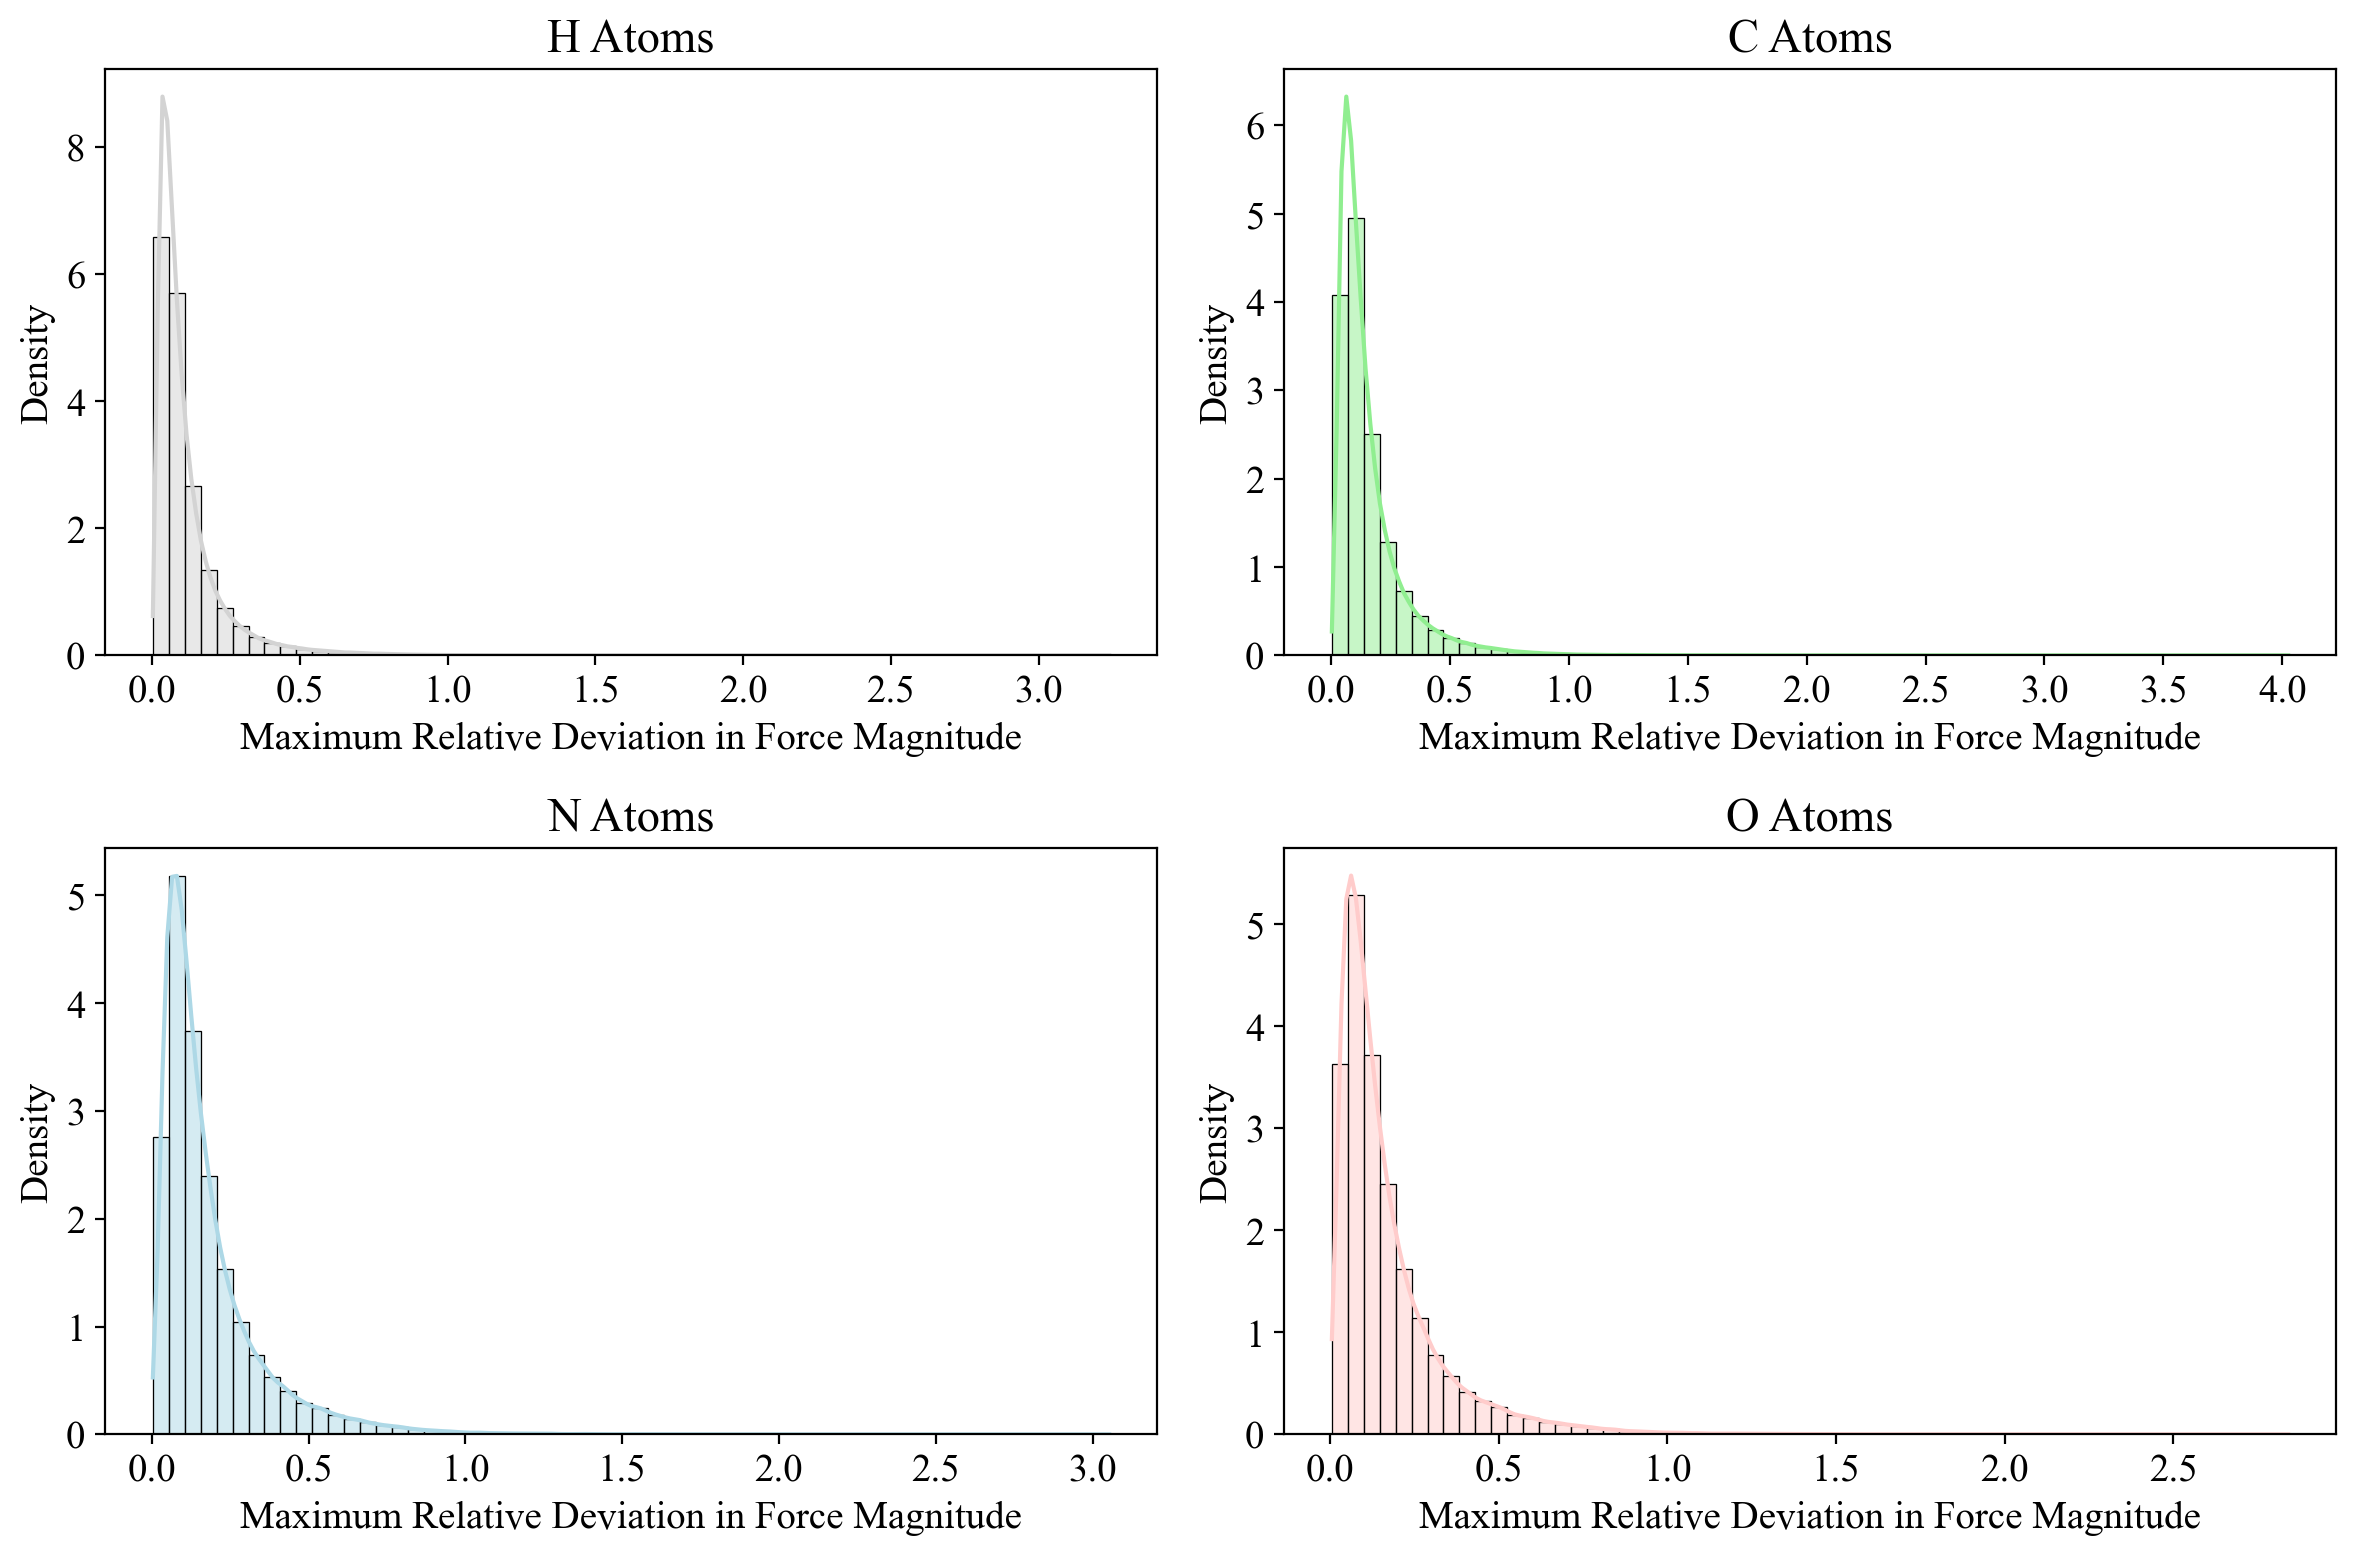

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors and labels
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
axes = axes.flatten()  # Flatten to iterate easily

# Loop over atom types and plot in separate subplots
for idx, (atom_type, (label, color)) in enumerate(atom_types_colors.items()):
    ax = axes[idx]
    sns.histplot(
        df_exploded[df_exploded["species"] == atom_type]["max_dev_per_atom"], 
        bins=60, kde=True, color=color, edgecolor="black", stat='density', ax=ax
    )
    
    ax.set_xlabel("Maximum Relative Deviation in Force Magnitude")
    ax.set_ylabel("Density")
    ax.set_title(f"{label} Atoms")  # Title with atom type label

# Adjust layout
plt.tight_layout()
plt.savefig('figures/forces/max_force_deviation_by_species_subplots.png')

# Show plot
plt.show()

In [52]:
df[df['weighted_force_stdev']>3.5]['max_dev_per_atom'].apply(max).mean()

np.float64(0.45705872836549666)

In [53]:
print(df_exploded)

         species  mean_magnitudes  max_dev_per_atom  weighted_force_stdev  \
0              8        49.098190          0.033481              1.694407   
1              8        26.852699          0.125189              1.694407   
2              7        27.365938          0.080309              1.694407   
3              6        37.756535          0.145429              1.694407   
4              6        59.490015          0.044814              1.694407   
...          ...              ...               ...                   ...   
2608853        1        72.286270          0.033388              4.017610   
2608854        1        69.310199          0.059751              4.017610   
2608855        1        84.027488          0.062390              4.017610   
2608856        1       112.870186          0.085650              4.017610   
2608857        1       119.198882          0.052482              4.017610   

         size_weighted_energy_error                                  id  
0

In [60]:
df_filtered = df_exploded[df_exploded['weighted_force_stdev'] > 3.45]


In [40]:
print('H atoms in COMP6v1', len(df_exploded[df_exploded['species']==1]))
print('C atoms in COMP6v1', len(df_exploded[df_exploded['species']==6]))
print('N atoms in COMP6v1', len(df_exploded[df_exploded['species']==7]))
print('O atoms in COMP6v1', len(df_exploded[df_exploded['species']==8]))
print('Total atoms in COMP6v1', len(df_exploded['species']))

H atoms in COMP6v1 1352100
C atoms in COMP6v1 890691
N atoms in COMP6v1 193592
O atoms in COMP6v1 172475
Total atoms in COMP6v1 2608858


In [61]:
# Filter the dataframe where max_dev_per_atom > 0.45
df_filtered = df_filtered[df_filtered['max_dev_per_atom'] > 0.45]

# Count atoms per species within the filtered dataframe
print('H atoms in COMP6v1_filtered:', len(df_filtered[df_filtered['species'] == 1]))
print('C atoms in COMP6v1_filtered:', len(df_filtered[df_filtered['species'] == 6]))
print('N atoms in COMP6v1_filtered:', len(df_filtered[df_filtered['species'] == 7]))
print('O atoms in COMP6v1_filtered:', len(df_filtered[df_filtered['species'] == 8]))
print('Total atoms in COMP6v1_filtered:', len(df_filtered))

H atoms in COMP6v1_filtered: 9575
C atoms in COMP6v1_filtered: 15625
N atoms in COMP6v1_filtered: 5430
O atoms in COMP6v1_filtered: 4166
Total atoms in COMP6v1_filtered: 34796


In [62]:
df_filtered

,species,mean_magnitudes,max_dev_per_atom,weighted_force_stdev,size_weighted_energy_error,id
2633,8,6.229701,1.040660,3.606155,0.066966,ANI-BenchMD-wB97X-631Gd/024-0-idx3
2634,7,11.965493,0.488958,3.606155,0.066966,ANI-BenchMD-wB97X-631Gd/024-0-idx3
2662,6,22.168998,0.465085,3.607773,0.440112,ANI-BenchMD-wB97X-631Gd/024-0-idx4
2705,8,20.064065,0.591988,4.323517,0.238823,ANI-BenchMD-wB97X-631Gd/024-0-idx6
2722,1,5.589298,0.628966,4.323517,0.238823,ANI-BenchMD-wB97X-631Gd/024-0-idx6
...,...,...,...,...,...,...
2605587,1,95.756065,0.841265,15.101283,3.876163,GDB13-13-wB97X-631Gd/035-0-idx17
2605744,6,21.491239,0.581858,4.761627,0.860100,GDB13-13-wB97X-631Gd/035-0-idx22
2606057,6,19.334665,0.480708,3.644386,0.202162,GDB13-13-wB97X-631Gd/035-0-idx31
2606071,1,5.927751,0.575809,3.644386,0.202162,GDB13-13-wB97X-631Gd/035-0-idx31


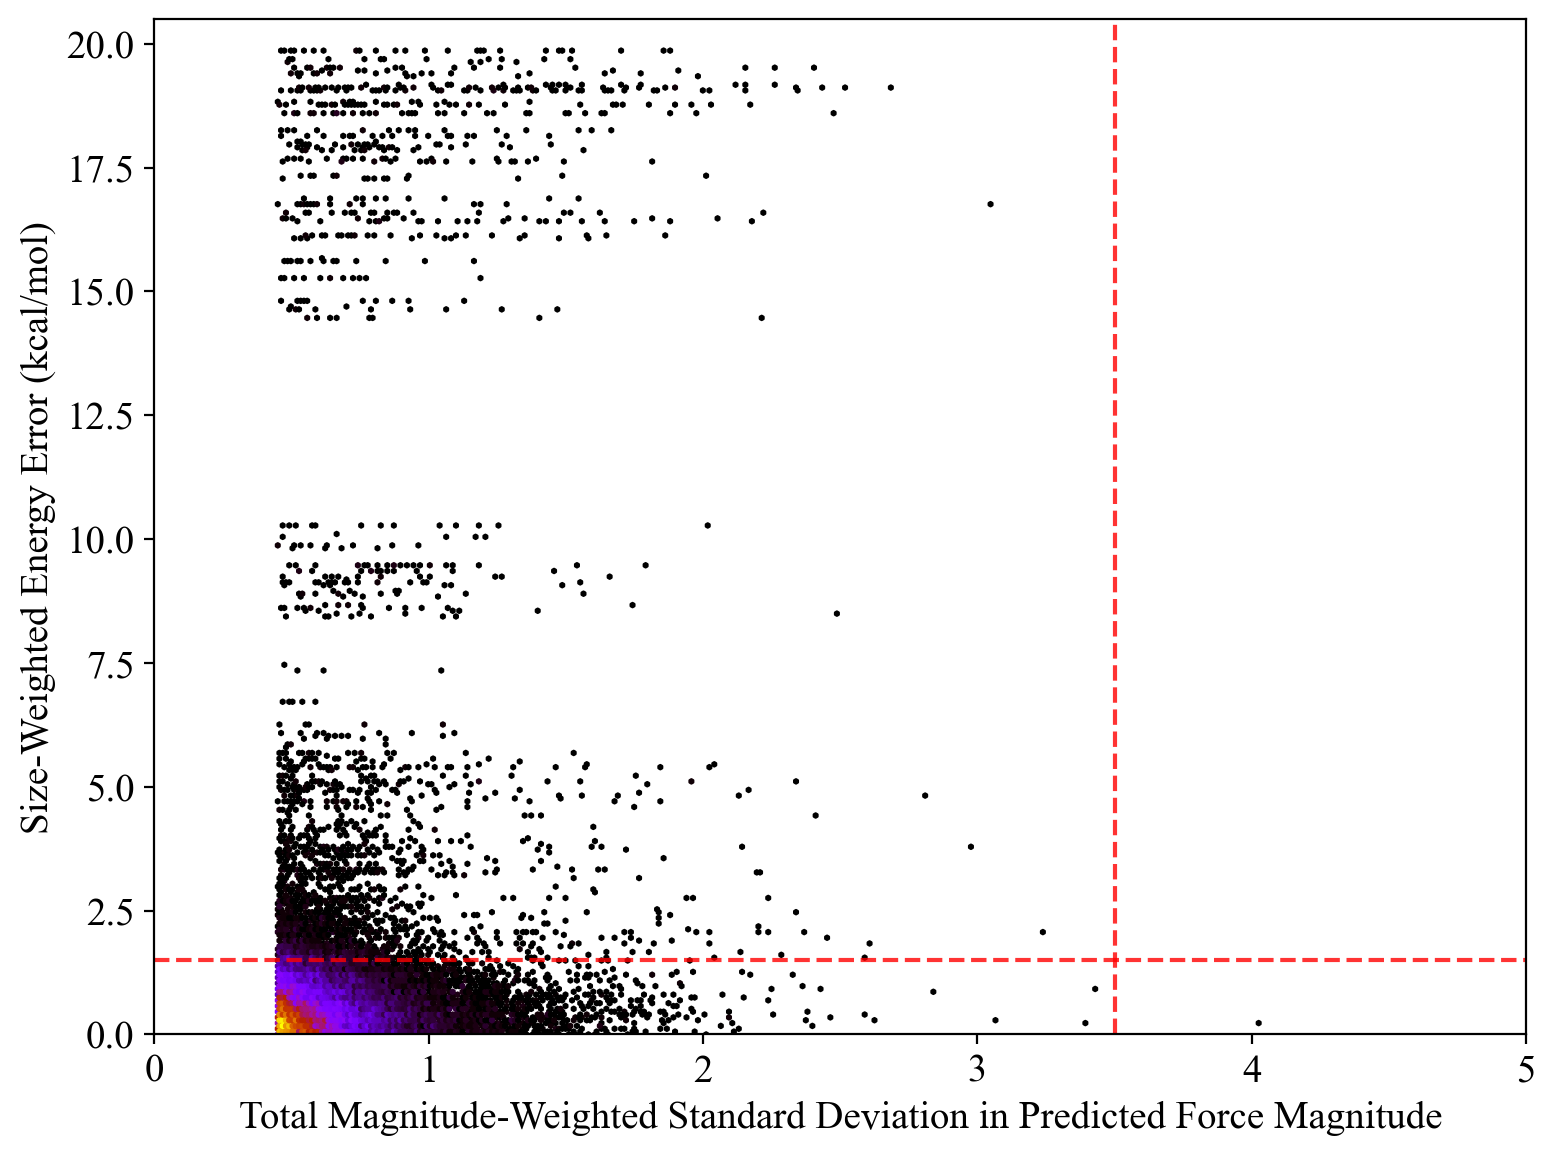

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Hexbin plot with weighted force stdev vs. energy error
#hb = 
plt.hexbin(df_filtered["max_dev_per_atom"], df_filtered
["size_weighted_energy_error"], 
                gridsize=300, cmap="gnuplot", mincnt=1)

plt.axhline(y=1.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Horizontal line at 1.5 kcal/mol
plt.axvline(x=3.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)  # Vertical line at 0.23 kcal/mol


plt.xlim(0,5)
plt.ylim(0,20.5)

# Add colorbar with bin count
#cbar_ax = plt.gca().inset_axes([0.86, 0.25, 0.02, 0.4])  # [x-position, y-position, width, height]
#cb = plt.colorbar(hb, cax=cbar_ax)
#cb.set_label("Count")  # Label the colorbar

# Labels and layout
plt.xlabel("Total Magnitude-Weighted Standard Deviation in Predicted Force Magnitude")
plt.ylabel("Size-Weighted Energy Error (kcal/mol)")
plt.tight_layout()

# Save and show plot
#plt.savefig('./figures/forces/lines_weighted_force_stdev-vs-energy_error.png')
plt.show()

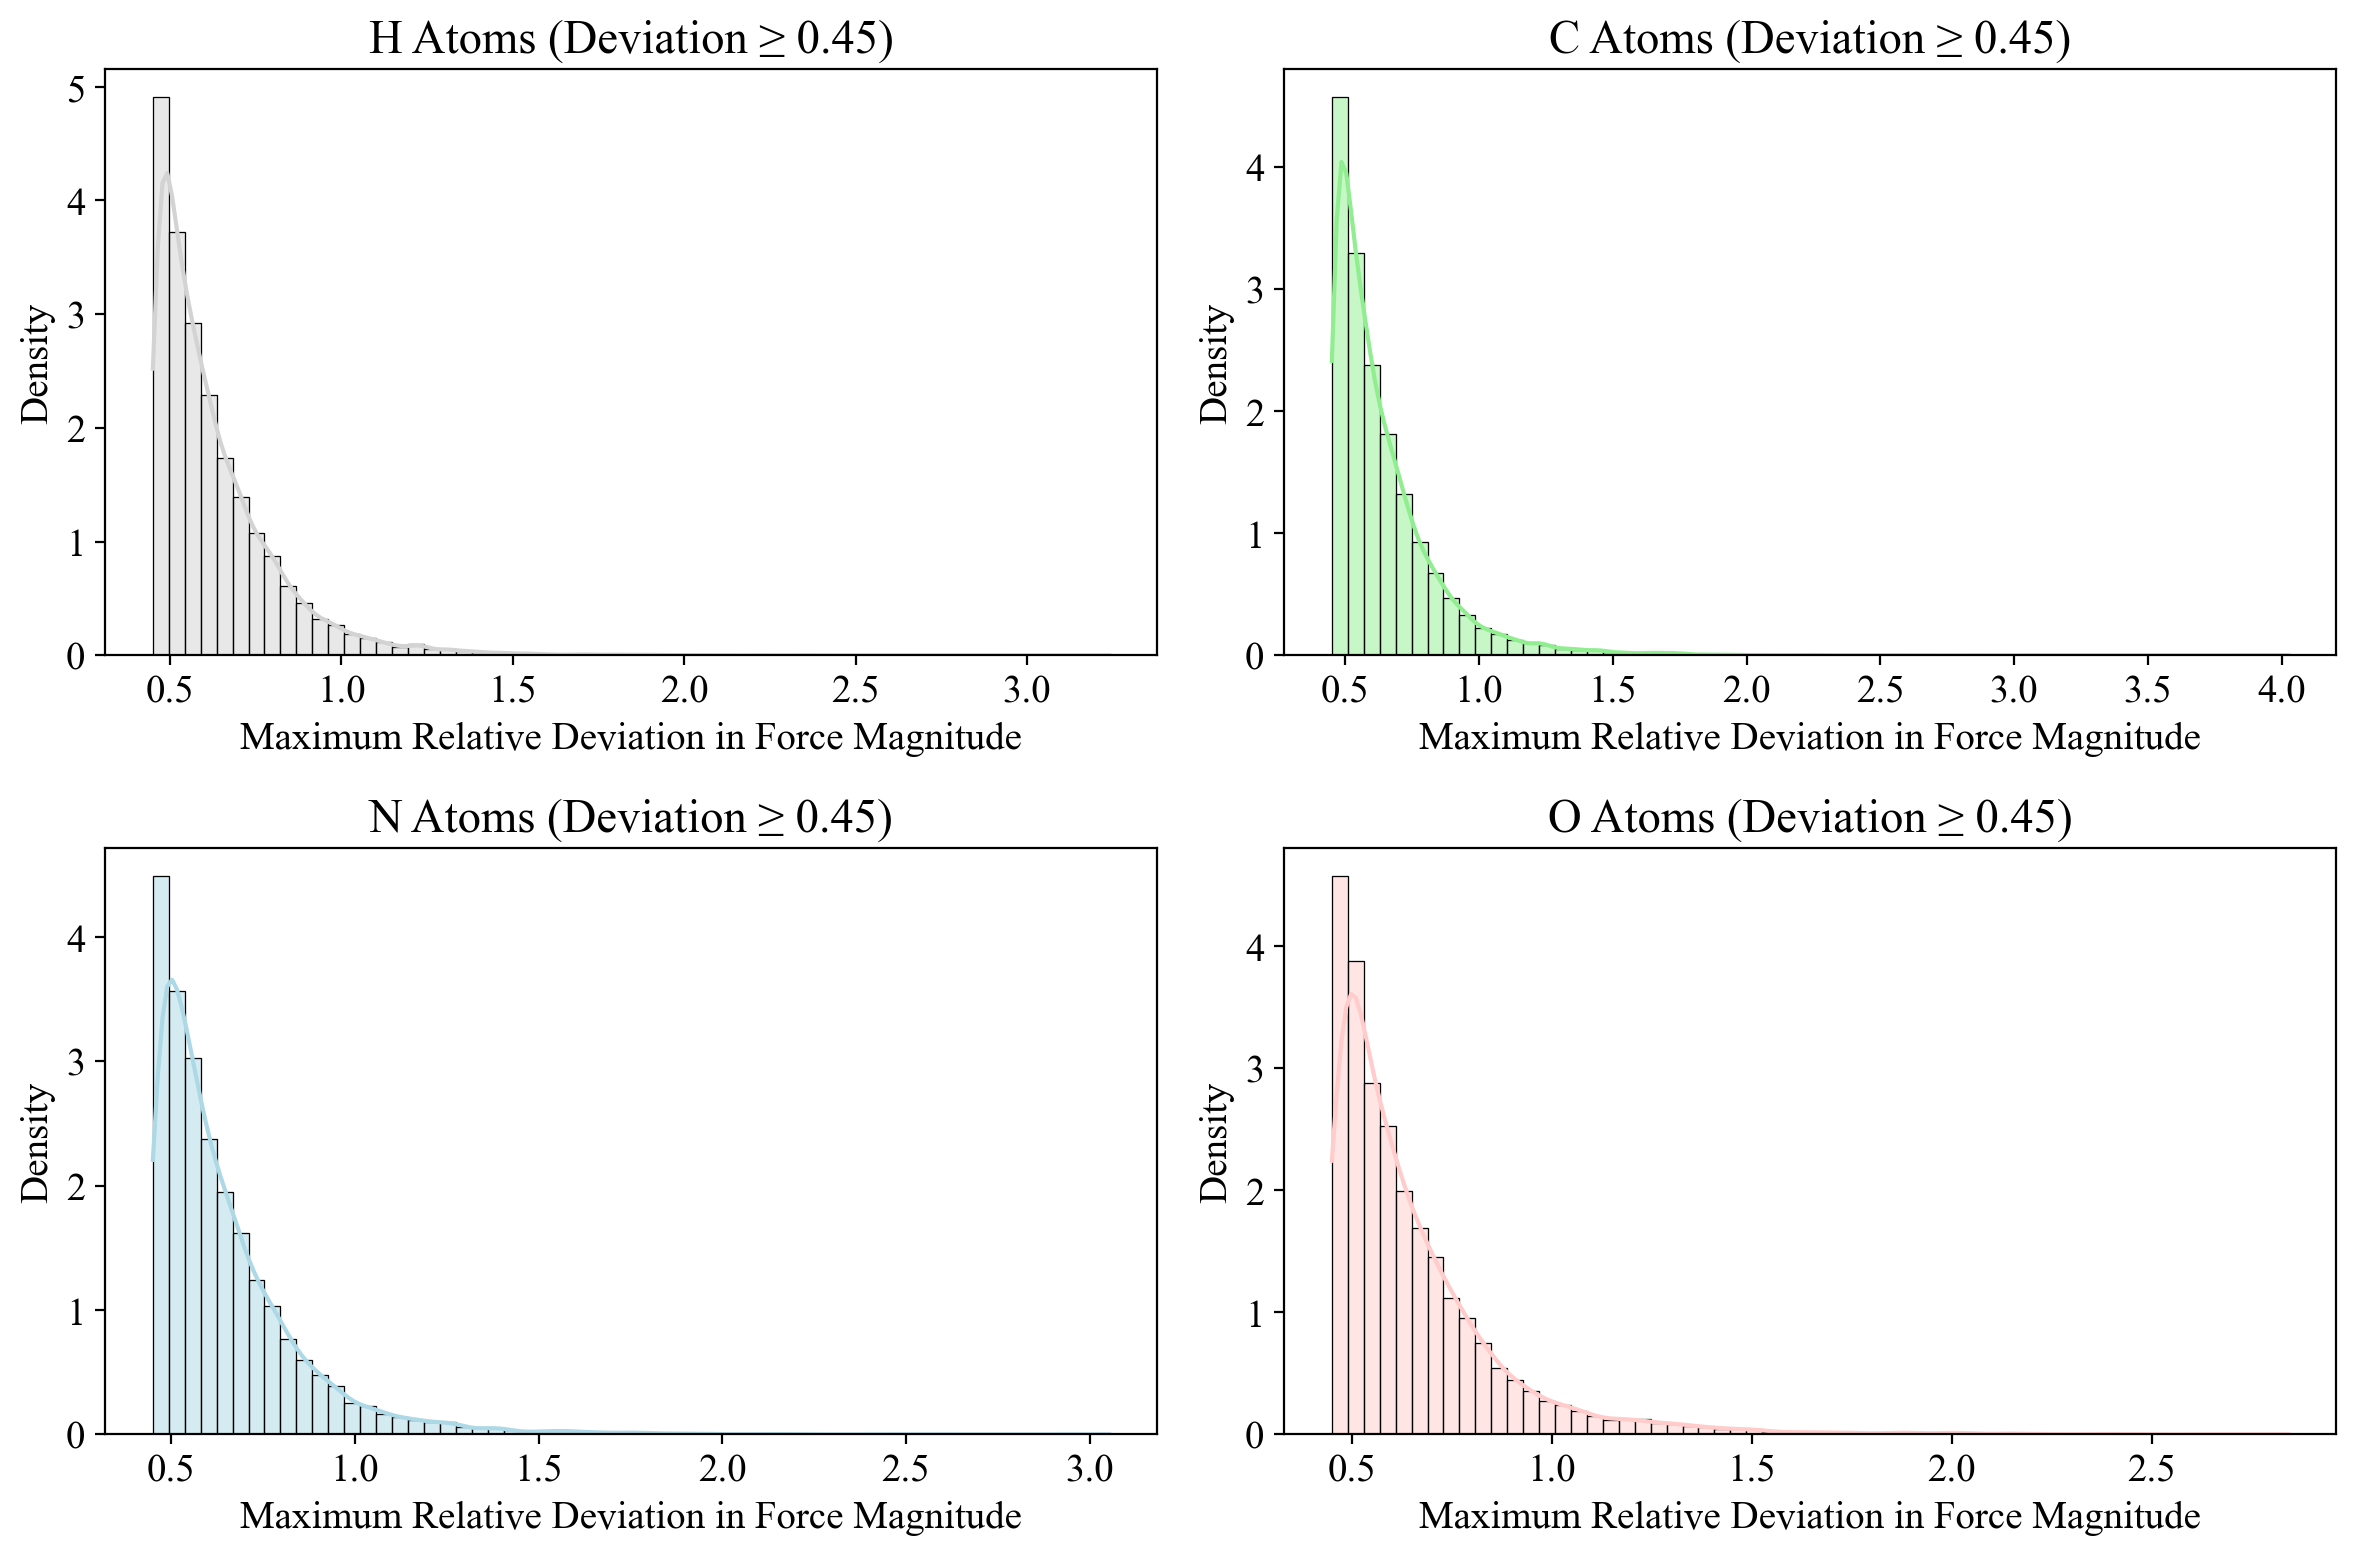

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors and labels
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid
axes = axes.flatten()  # Flatten to iterate easily

# Loop over atom types and plot in separate subplots
for idx, (atom_type, (label, color)) in enumerate(atom_types_colors.items()):
    ax = axes[idx]
    
    # Filter data: Only include atoms where max_dev_per_atom >= 0.45
    filtered_data = df_exploded[(df_exploded["species"] == atom_type) & 
                                (df_exploded["max_dev_per_atom"] >= 0.45)]
    
    sns.histplot(
        filtered_data["max_dev_per_atom"], 
        bins=60, kde=True, color=color, edgecolor="black", stat='density', ax=ax
    )
    
    ax.set_xlabel("Maximum Relative Deviation in Force Magnitude")
    ax.set_ylabel("Density")
    ax.set_title(f"{label} Atoms (Deviation ≥ 0.45)")  # Indicate filtering in title

# Adjust layout
plt.tight_layout()
plt.savefig('figures/forces/max_force_deviation_by_species_filtered.png')

# Show plot
plt.show()